In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from state import State

from nodes import *

from chains import *

from langgraph.graph import END, StateGraph, START

from langgraph.checkpoint.memory import MemorySaver

from langchain_teddynote.graphs import visualize_graph

from langchain_core.runnables import RunnableConfig

In [6]:
workflow = StateGraph(State)

workflow.add_node("input_parser", InputParserNode())
workflow.add_node("rubric_generator", RubricNode())
workflow.add_node("evaluation_generator", EvaluationNode())
workflow.add_node("feedback_generator", FeedbackNode())
workflow.add_node("report_generator", ReportNode())

workflow.add_edge(START, "input_parser")
workflow.add_edge("input_parser", "rubric_generator")

workflow.add_conditional_edges(
    source="rubric_generator",
    path=EvaluationRouterNode(),
    path_map={"evaluation_generator": "evaluation_generator", "END": END},
)

workflow.add_edge("evaluation_generator", "feedback_generator")
workflow.add_edge("feedback_generator", "report_generator")

workflow.add_edge("report_generator", END)


memory_saver = MemorySaver()
app = workflow.compile(checkpointer=memory_saver)

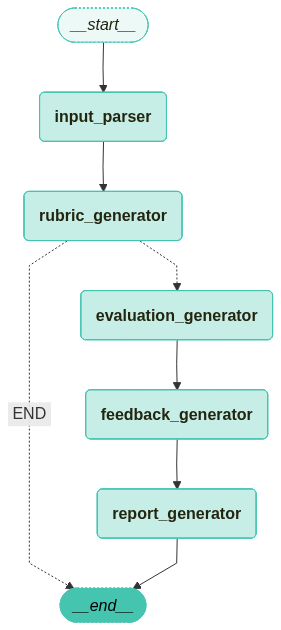

In [7]:
visualize_graph(app)

In [8]:
# Fixed: Convert string to proper dictionary format
teacher_input = """

"topic": "지구 문제에 우리는 어떻게 대쳐하는가?(환경문제)",

"objective": "환경 논제 글쓰기",

"grade_level": "초등학교 6학년",

"name": "이종복",

"student_submission": "요즘 뉴스나 학교에서 환경문제에 대해 많이 배우고 있습니다. 지구에는 여러 가지 문제가 생기고 있는데, 그 중에서도 지구 온난화, 쓰레기 문제, 공기 오염이 심각합니다.

이런 문제를 그냥 두면, 우리가 살기 힘든 지구가 될 수 있습니다. 그래서 우리는 작은 일부터 실천해야 합니다. 예를 들어, 분리수거를 잘하기, 물을 아껴 쓰기, 전기를 아껴 쓰기, 일회용품을 덜 쓰기 같은 일이 있습니다.

우리 가족은 장을 볼 때 에코백을 가져가고, 집에서는 텀블러를 사용합니다. 또 저는 친구들과 함께 학교에서 쓰레기 줍기 활동에도 참여했습니다. 이런 작은 실천들이 모이면 지구를 살리는 데 도움이 된다고 생각합니다.

지구는 우리 모두가 함께 살아가는 소중한 집입니다. 앞으로도 환경을 생각하며 행동하는 사람이 되고 싶습니다."
"""

In [19]:
config = RunnableConfig(
        recursion_limit=10,
        configurable={"thread_id": "aa11111"},
    )

generated_results = app.invoke({"teacher_input": teacher_input}, config=config)

==== [Generating Rubric] ====
Topic: 지구 문제에 우리는 어떻게 대쳐하는가?(환경문제)
Objective: 환경 논제 글쓰기
Grade Level: 6
==== [Evaluating Submission] ====
==== [Generating Feedback] ====
==== [Generating Report] ====


In [9]:
async def response(teacher_input: str, thread_id: str) -> State:

    config = RunnableConfig(
        recursion_limit=10,
        configurable={"thread_id": thread_id},
    )

    inputs = {"teacher_input": teacher_input}
    results = app.astream(inputs, config=config, stream_mode="updates")

    async for chunk in results:

        for node_name, node_state in chunk.items():
            if node_name == "input_parser":
                print("=" * 50)
                print("📋 입력 정보")
                print("=" * 50)

                for key, value in node_state["teacher_input"]:
                    if key == "student_submission":
                        print(f"📝 {key.replace('_', ' ').title()}:")
                        print("-" * 30)
                        print(value)
                        print()
                    else:
                        print(f"🔹 {key.replace('_', ' ').title()}: {value}")

                print("=" * 50)

            else:
                print(f"\n[Node: {node_name}]\n")

                for key, value in node_state.items():
                    print(value)

In [11]:
generated_results = await response(teacher_input, "aa212")

📋 입력 정보
🔹 Grade Level: 6
🔹 Topic: 지구 문제에 우리는 어떻게 대쳐하는가?(환경문제)
🔹 Objective: 환경 논제 글쓰기
🔹 Name: 이종복
📝 Student Submission:
------------------------------
요즘 뉴스나 학교에서 환경문제에 대해 많이 배우고 있습니다. 지구에는 여러 가지 문제가 생기고 있는데, 그 중에서도 지구 온난화, 쓰레기 문제, 공기 오염이 심각합니다.

이런 문제를 그냥 두면, 우리가 살기 힘든 지구가 될 수 있습니다. 그래서 우리는 작은 일부터 실천해야 합니다. 예를 들어, 분리수거를 잘하기, 물을 아껴 쓰기, 전기를 아껴 쓰기, 일회용품을 덜 쓰기 같은 일이 있습니다.

우리 가족은 장을 볼 때 에코백을 가져가고, 집에서는 텀블러를 사용합니다. 또 저는 친구들과 함께 학교에서 쓰레기 줍기 활동에도 참여했습니다. 이런 작은 실천들이 모이면 지구를 살리는 데 도움이 된다고 생각합니다.

지구는 우리 모두가 함께 살아가는 소중한 집입니다. 앞으로도 환경을 생각하며 행동하는 사람이 되고 싶습니다.

==== [Generating Rubric] ====
Topic: 지구 문제에 우리는 어떻게 대쳐하는가?(환경문제)
Objective: 환경 논제 글쓰기
Grade Level: 6

[Node: rubric_generator]

```markdown
# 6학년 환경 논제 글쓰기 평가 루브릭  
**주제:** 지구 문제에 우리는 어떻게 대처하는가? (환경문제)  
**목적:** 환경 문제에 대한 자신의 생각을 논리적으로 표현하는 글쓰기  

| 평가 기준       | 상 (4점)                                         | 중 (3점)                                         | 하 (2점)                                         | 미흡 (1점)                           